# Spatial transcriptomics unveils the in situ cellular and molecular hallmarks of the lung in fatal COVID-19

# Spatial communication events across COVID-19 induced DAD progression

**Author:** Carlos A. Garcia-Prieto

* This notebook explains the downstream analysis of the spatially mapped and deconvoluted Visium ST data with cell2location, focusing on cell-cell communication events, including spatial co-expression of ligand-receptor pairs, transcription factors actvity, their spatial dependencies with cell type abundances, including identification of causal intracellular signaling networks.
* We followed LIANA+ spatially-informed [bivariate metrics](https://liana-py.readthedocs.io/en/latest/notebooks/bivariate.html), [MISTy](https://liana-py.readthedocs.io/en/latest/notebooks/misty.html), [downstream signaling networks](https://liana-py.readthedocs.io/en/latest/notebooks/targeted.html#Intracellular-Signaling-Networks) and [decoupleR](https://decoupler-py.readthedocs.io/en/latest/notebooks/spatial.html) tutorials.

## Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')
import anndata
import pandas as pd
import scanpy as sc
import plotnine as p9
#!pip install "decoupler>=1.4.0"
import decoupler as dc
import liana as li
from liana.method import MistyData, genericMistyData, lrMistyData
import mudata
from mudata import MuData
import numpy as np
#!pip install squidpy
import squidpy as sq
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt 
import matplotlib as mpl
#import scvi
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs
import cell2location
from cell2location.utils import select_slide
import graphcompass as gc
import os
from scipy.cluster.hierarchy import linkage, dendrogram
import seaborn as sns
import scipy.stats as st
import omnipath as op
import graphviz 
import corneto as cn

Created a temporary directory at /tmp/tmphckg37il
Writing /tmp/tmphckg37il/_remote_module_non_scriptable.py


## Read integrated VISIUM ST data with estimated cell type abundances

In [2]:
#Set result folders
results_folder = "/mnt/beegfs/cgarcia/Spatial/COVID19/cell2location/HLCA_publication/HLCA/"

#Create directory for LIANA+ results
directory = f'{results_folder}/liana'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

liana_folder = f'{results_folder}/liana/'

#Create directory for bivariate metrics results
directory = f'{results_folder}/liana/bivariate'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

bivariate_folder = f'{results_folder}/liana/bivariate/'

#Create directory for TF enrichment results with decoupleR
directory = f'{results_folder}/liana/decoupler'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

decoupler_folder = f'{results_folder}/liana/decoupler/'

ref_run_name = f'{results_folder}reference_signatures_finest'
run_name = f'{results_folder}cell2location_map_finest'

In [3]:
#Read anndata with NMF compartments results:
adata_file = f"{run_name}/ad_vis_post_distrib_finest_discrete_region_NMF_lineage_Paper.h5ad"
adata_vis = sc.read_h5ad(adata_file)

In [4]:
#Replace Ensembl ids with Hugo symbols
adata_vis.var['Ensembl'] = adata_vis.var_names
adata_vis.var.set_index('SYMBOL', drop=True, inplace=True)

## Spatially informed bivariate metrics of ligand-receptor interactions (LRIs)

In [5]:
#Select minimum expression proportion for ligands/receptors
suffix = "With005MinimumExpr"

In [6]:
#Create directory for LRIs results
directory = f'{results_folder}/liana/bivariate/anndata{suffix}'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

## Compute local Cosine similarity of LRIs per Visium ST slide

In [7]:
#Function to save local Cosine similarity LR scores with 0.05 Minimum expr. proportion for ligands/receptors and their subunits:
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

for sample in samples:
    print(sample)
    #Select sample
    adata = select_slide(adata_vis, f'{sample}')
    #Compute spatial neighbors
    li.ut.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)
    #Format anndata
    adata.var = adata.var.rename_axis(None) #axis=1,axis="columns"
    #Compute bivariate metrics
    li.mt.lr_bivar(adata,
                   function_name='cosine', # Name of the function
                   n_perms=100, # Number of permutations to calculate a p-value
                   mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                   add_categories=True, # Whether to add local categories to the results
                   expr_prop=0.05, # Minimum expr. proportion for ligands/receptors and their subunits
                   use_raw=False,
                   verbose=False
                   )
    lrdata = adata.obsm['local_scores']
    # Save anndata object with local scores
    lr_file_linear = f"{bivariate_folder}anndata{suffix}/bivariate_LR_{sample}_{suffix}_Paper.h5ad"
    lrdata.write(lr_file_linear)
    

L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


## Compute local Moran's R of LRIs per Visium ST slide

In [8]:
#Function to save local LR MoransR scores with 0.05 Minimum expr. proportion for ligands/receptors and their subunits:
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

for sample in samples:
    print(sample)
    #Select sample
    adata = select_slide(adata_vis, f'{sample}')
    #Compute spatial neighbors
    li.ut.spatial_neighbors(adata, bandwidth=200, cutoff=0.1, kernel='gaussian', set_diag=True)
    #Format anndata
    adata.var = adata.var.rename_axis(None) #axis=1,axis="columns"
    #Compute bivariate metrics
    li.mt.lr_bivar(adata,
                   function_name='morans', # Name of the function
                   n_perms=100, # Number of permutations to calculate a p-value
                   mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                   add_categories=True, # Whether to add local categories to the results
                   expr_prop=0.05, # Minimum expr. proportion for ligands/receptors and their subunits
                   use_raw=False,
                   verbose=False
                   )
    lrdata = adata.obsm['local_scores']
    # Save anndata object with local scores
    lr_file_linear = f"{bivariate_folder}anndata{suffix}/bivariate_LR_{sample}_{suffix}_MoransR_Paper.h5ad"
    lrdata.write(lr_file_linear)
    

L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


## Read individual anndata objects with local bivariate Cosine similarity scores and export "global" scores (by averaging local scores across all spots) to use them as a global summary: Global mean Cosine similarity of LRIs

In [9]:
#Function to read  anndata and concatenate results:
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

appended_data_cosine_metrics = []
appended_data_sd_cosine_metrics = [] #append standard deviation

for sample in samples:
    print(sample)
    adata = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_{sample}_{suffix}_Paper.h5ad")
    #Extract scores
    cosine_metrics = adata.uns['global_res'].sort_values("global_mean", ascending=False)
    sd_cosine_metrics = adata.uns['global_res'].sort_values("global_sd", ascending=False)
    cosine_metrics["sample"] = sample
    sd_cosine_metrics["sample"] = sample
    appended_data_cosine_metrics.append(cosine_metrics)
    appended_data_sd_cosine_metrics.append(sd_cosine_metrics)
    
#Transform data
appended_data_cosine_metrics = pd.concat(appended_data_cosine_metrics)
appended_data_sd_cosine_metrics = pd.concat(appended_data_sd_cosine_metrics)

# write appended results to DataFrame 
appended_data_cosine_metrics.to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_mean_Cosine_{suffix}_appended_Paper.csv", index=True)
appended_data_sd_cosine_metrics.to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_mean_Cosine_sd_{suffix}_appended_Paper.csv", index=True)


L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


In [10]:
#Read global mean Cosine similarity results
cosine_metrics = pd.read_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_mean_Cosine_{suffix}_appended_Paper.csv", index_col = 0)

In [11]:
#Read global mean Cosine similarity standard deviation (sd) results
sd_cosine_metrics = pd.read_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_mean_Cosine_sd_{suffix}_appended_Paper.csv", index_col = 0)

## Read individual anndata objects with local Moran's R scores and export "global" summary: Global Moran's R of LRIs

In [12]:
#Function to read  anndata and concatenate results:
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

appended_data_moransr_metrics = []

for sample in samples:
    print(sample)
    adata = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_{sample}_{suffix}_MoransR_Paper.h5ad")
    #Transform to MistyData
    moransr_metrics = adata.uns['global_res'].sort_values("global_r", ascending=False)
    moransr_metrics["sample"] = sample
    appended_data_moransr_metrics.append(moransr_metrics)
    
#Transform data
appended_data_moransr_metrics = pd.concat(appended_data_moransr_metrics)

# write DataFrame 
appended_data_moransr_metrics.to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_MoransR_{suffix}_appended_Paper.csv", index=True)


L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


In [13]:
#Read global Moran's R results
moransr_metrics = pd.read_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_MoransR_{suffix}_appended_Paper.csv", index_col = 0)
moransr_metrics = moransr_metrics.sort_values("global_r", ascending=False)

## Concatenate individual annData objects with local Cosine similarity scores of LRIs

In [14]:
#Read individual anndata objects with Cosine similarity LRI scores per sample
adata_L2P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L2P_{suffix}_Paper.h5ad")
adata_L19P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L19P_{suffix}_Paper.h5ad")
adata_L11P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L11P_{suffix}_Paper.h5ad")
adata_HRC5_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC5_{suffix}_Paper.h5ad")
adata_HRC6_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC6_{suffix}_Paper.h5ad")
adata_HRC8_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC8_{suffix}_Paper.h5ad")
adata_HRC10_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC10_{suffix}_Paper.h5ad")
adata_HRC11_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC11_{suffix}_Paper.h5ad")
adata_HRC12_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC12_{suffix}_Paper.h5ad")
adata_HRC13_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC13_{suffix}_Paper.h5ad")
adata_HRC16_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC16_{suffix}_Paper.h5ad")
adata_HRC17_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC17_{suffix}_Paper.h5ad")
adata_L5P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L5P_{suffix}_Paper.h5ad")
adata_L14P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L14P_{suffix}_Paper.h5ad")
adata_L24P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L24P_{suffix}_Paper.h5ad")
adata_L12P_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L12P_{suffix}_Paper.h5ad")
adata_HRC2_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC2_{suffix}_Paper.h5ad")
adata_HRC4_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC4_{suffix}_Paper.h5ad")
adata_HRC18_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_HRC18_{suffix}_Paper.h5ad")
adata_L3C_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L3C_{suffix}_Paper.h5ad")
adata_L14C_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L14C_{suffix}_Paper.h5ad")
adata_L2C_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_L2C_{suffix}_Paper.h5ad")
adata_CONTROL2_biv = anndata.read(f"{bivariate_folder}anndata{suffix}/bivariate_LR_CONTROL2_{suffix}_Paper.h5ad")

In [15]:
#Concatenate anndata objects with local Cosine similarity scores of LRIs
adata_LR_biv = anndata.concat(
    {"L2P" : adata_L2P_biv, "L5P" : adata_L5P_biv, "L14P" : adata_L14P_biv, "L19P" : adata_L19P_biv, "L24P" : adata_L24P_biv, "L3C" : adata_L3C_biv, "L14C" : adata_L14C_biv,
    "L2C" : adata_L2C_biv, "L11P" : adata_L11P_biv, "L12P" : adata_L12P_biv,
    "CONTROL2": adata_CONTROL2_biv, "HRC2": adata_HRC2_biv, "HRC4": adata_HRC4_biv, "HRC5": adata_HRC5_biv,
    "HRC6": adata_HRC6_biv, "HRC8": adata_HRC8_biv, "HRC10": adata_HRC10_biv, "HRC11": adata_HRC11_biv, "HRC12": adata_HRC12_biv, "HRC13": adata_HRC13_biv,
    "HRC16": adata_HRC16_biv, "HRC17": adata_HRC17_biv, "HRC18": adata_HRC18_biv},
    label = "sample",
    #index_unique="_",
    join = "inner",
    merge = "unique",
    uns_merge = "unique",
    pairwise = False,
    axis=0,
)

# Identify intercellular communication signatures using non-negative matrix factorization (NMF)

In [16]:
#Identify intercellular patterns
li.multi.nmf(adata_LR_biv, n_components=None, inplace=True, random_state=0, max_iter=200, verbose=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:22<00:00,  2.52s/it]
Estimated rank: 3


In [17]:
#Save anndata object with NMF results
nmf_adata_LR_biv = f"{bivariate_folder}anndata{suffix}/bivariate_lr_adata_concat_{suffix}_Paper.h5ad"
adata_LR_biv.write(nmf_adata_LR_biv)

In [18]:
# Extract NMF variable loadings
lr_loadings = li.ut.get_variable_loadings(adata_LR_biv, varm_key='NMF_H').set_index('index')

In [19]:
#Write NMF loading Results
lr_loadings.sort_values("Factor1", ascending=False).to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_nmf_loadings_adata_concat_{suffix}_Paper.csv", index=True) 

<div class="alert alert-info">
<b>Paper Table!</b>
Table S1
</div>

In [20]:
#Select Factor 3 loadings
Factor3_loadings = lr_loadings.sort_values("Factor3", ascending=False)
Factor3_loadings = Factor3_loadings["Factor3"]
Factor3_loadings.to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_nmf_factor3_loadings_adata_concat_{suffix}_TableS1_Paper.csv", index=True) 

In [21]:
# Extract NMF scores
factor_scores = li.ut.get_factor_scores(adata_LR_biv, obsm_key='NMF_W')

In [22]:
#Write NMF scores
factor_scores.sort_values("Factor1", ascending=False).to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_nmf_factor_scores_adata_concat_{suffix}_Paper.csv", index=True) 

In [23]:
#Convert NMF Factor scores to an AnnData object for plotting
nmf = sc.AnnData(X=adata_LR_biv.obsm['NMF_W'],
                    obs=adata_LR_biv.obs,
                    var=pd.DataFrame(index=lr_loadings.columns),
                    uns=adata_LR_biv.uns,
                    obsm=adata_LR_biv.obsm)

In [24]:
#Save anndata object with NMF results
nmf_file_linear = f"{bivariate_folder}anndata{suffix}/bivariate_lr_nmf_adata_concat_{suffix}_Paper.h5ad"
nmf.write(nmf_file_linear)

## Compute average NMF scores per Visium ST slide

In [25]:
#Calculate average factor scores per slide
factor_scores['Sample'] = factor_scores['index'].str.split('_').str[1]

In [26]:
#Annotate samples
proliferative = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17"]
acute = ["L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18"]
controls = ["L3C","L14C","L2C","CONTROL2"]

In [27]:
factor_scores['condition_subtype'] = np.where(factor_scores['Sample'].isin(acute) == True, 'Acute', (np.where(factor_scores['Sample'].isin(proliferative) == True, 'Proliferative', 'Control')))

In [28]:
factor_scores_by_sample = factor_scores.groupby('Sample', as_index=False)[['Factor1','Factor2','Factor3']].mean()

In [29]:
factor_scores_by_condition = factor_scores.groupby('condition_subtype', as_index=False)[['Factor1','Factor2','Factor3']].mean()

## Perform hierarchical clustering on average NMF scores

In [30]:
#Prepare data
factor_scores_by_sample.set_index('Sample', drop=True, inplace=True)

In [31]:
#Compute hiearchical clustering based on average factor scores per slide
ward_clustering = linkage(factor_scores_by_sample, method="ward", metric="euclidean")

In [32]:
#Prepare data for heatmap
factor_scores_by_sample_transposed = factor_scores_by_sample.transpose()

In [33]:
#Set row colors
colors = np.where(factor_scores_by_sample_transposed.columns.isin(acute) == True, '#1f77b4', (np.where(factor_scores_by_sample_transposed.columns.isin(proliferative) == True, '#2ca02c', '#ff7f0e')))

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figure 3A
</div>

In [34]:
#Plot heatmap
with plt.rc_context():  # Use this to set figure params like size and dpi
    sns.clustermap(factor_scores_by_sample_transposed,figsize = (8, 6), dendrogram_ratio = 0.3, method = "ward", metric = "euclidean", col_colors=colors) 
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Heatmap_Factor_Scores_Ward_{suffix}_Cosine_Paper.png",dpi=300, format="png")
    plt.close()

## Plot NMF scores on Visium ST samples

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figure 3C & Panel Figure 4B
</div>

In [35]:
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

for sample in samples:
    print(sample)
    #Select sample
    nmf_slide = select_slide(nmf, f'{sample}')
    #Plot
    with mpl.rc_context({'axes.facecolor':  'white',
                            'figure.figsize': [6, 6]}):
        sc.pl.spatial(nmf_slide, color=[*nmf_slide.var.index, None], size=1.4, ncols=2, show=False)
        plt.savefig(f"{bivariate_folder}anndata{suffix}/bivariate_LR_Factor_Scores_{suffix}_{sample}_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")
        plt.close()

L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


# Perform pathway enrichment analysis on LRI results

In [36]:
# Get CollecTRI transcription factor (TF) resource
net_collectri = dc.get_collectri(organism='human', split_complexes=False)

In [37]:
#Write net_collectri
net_collectri.to_csv(f"{bivariate_folder}anndata{suffix}/net_collectri_Paper.csv", index=True) 

In [38]:
# Get PROGENy pathway genesets resource
net_progeny = dc.get_progeny(organism='human', top=5000)

In [39]:
#Remove estrogen and androgen sources to avoid eventual biological sex biases (studied cohort with 7 females and 16 males)
net_progeny = net_progeny.loc[~net_progeny['source'].isin(['Estrogen','Androgen'])]

In [40]:
#Write net_progeny
net_progeny.to_csv(f"{bivariate_folder}anndata{suffix}/net_progeny_Paper.csv", index=True) 

## Assign LRIs to pathway genesets using LIANA+ Consensus resource

In [41]:
#Load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [43]:
#Generate ligand-receptor geneset
lr_progeny = li.rs.generate_lr_geneset(lr_pairs, net_progeny, lr_separator="^")

In [44]:
#Run enrichment analysis using multivariate linear regression (mlm)
estimate, pvals = dc.run_mlm(mat=lr_loadings.transpose(), net=lr_progeny, source="source", target="interaction", weight="weight", use_raw=False, verbose=True, min_n=1)

Running mlm on mat with 3 samples and 146 targets for 12 sources.


In [45]:
#Write mlm estimates
estimate.to_csv(f"{bivariate_folder}anndata{suffix}/Estimate_LR_Loadings_PROGENY_mlm_{suffix}_cosine_Paper.csv", index=True) 

In [46]:
#Write mlm pvalues
pvals.to_csv(f"{bivariate_folder}anndata{suffix}/Estimate_LR_pvalues_PROGENY_mlm_{suffix}_cosine_Paper.csv", index=True) 

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figure 3B
</div>

In [47]:
#Heatmap with pathway enrichment scores
with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [6, 6]}):
    sns.heatmap(estimate, square=True, cmap='RdBu_r')
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Estimate_LR_Loadings_PROGENY_mlm_{suffix}_cosine_heatmap_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")
    plt.close()

# Transcription factor activity inference

To infer transcription factor (TF) enrichment scores we use CollecTRI (a gene regulatory network (GRN) containing TFs and their transcriptional targets) and a multivariate linear model (mlm) run with decoupleR. For each spot and each TF, it fits a linear model that predicts the observed gene expression based on the TF-Gene interactions weights. The score is the t-value of the slope.

In [48]:
dc.run_mlm(
    mat=adata_vis,
    net=net_collectri,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False,
    min_n=5
)

1 features of mat are empty, they will be removed.
Running mlm on mat with 91068 samples and 5849 targets for 523 sources.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.53s/it]


In [49]:
#Rename results
adata_vis.obsm['collectri_mlm_estimate'] = adata_vis.obsm['mlm_estimate'].copy()
adata_vis.obsm['collectri_mlm_pvals'] = adata_vis.obsm['mlm_pvals'].copy()
del(adata_vis.obsm["mlm_estimate"])
del(adata_vis.obsm["mlm_pvals"])

In [50]:
# Save anndata object with TF enrichment results
adata_vis_mlm_file = f"{bivariate_folder}anndata{suffix}/ad_vis_post_distrib_finest_discrete_region_NMF_lineage_decoupler_mlm_Paper.h5ad"
adata_vis.write_h5ad(adata_vis_mlm_file)

## Visualization of TFs activities

In [51]:
#Extract TF enrichment scores
acts_collectri_full_mlm = dc.get_acts(adata_vis, obsm_key='collectri_mlm_estimate')

In [53]:
#Save extracted TFs activities
acts_collectri_full_mlm_file = f"{bivariate_folder}anndata{suffix}/acts_collectri_full_mlm_Paper.h5ad"
acts_collectri_full_mlm.write(acts_collectri_full_mlm_file)

### Identify top TFs per condition

In [54]:
df_collectri_mlm = dc.rank_sources_groups(acts_collectri_full_mlm, groupby='condition_subtype', reference='rest', method='t-test_overestim_var')

<div class="alert alert-info">
<b>Paper Table!</b>
Table S2
</div>

In [55]:
#Save top TFs enriched per condition
df_collectri_mlm.to_csv(f"{bivariate_folder}anndata{suffix}/Collectri_full_mlm_Paper.csv", index=True)

### Extract top 10 TFs per condition

In [56]:
n_markers = 10
source_markers_collectri_mlm = df_collectri_mlm.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()

## Plot heatmap with top 10 enriched TFs per condition

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figure 3D
</div>

In [57]:
with mpl.rc_context({'axes.facecolor':  'white',
                        'figure.figsize': [3, 6]}):
    sc.pl.matrixplot(acts_collectri_full_mlm, source_markers_collectri_mlm, 'condition_subtype', dendrogram=False, standard_scale='var',
                     colorbar_title='Z-scaled scores', cmap='RdBu_r', show=False)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Collectri_full_mlm_heatmap_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")
    plt.close()

## Plot top 10 enriched TFs per condition on Visium ST slides

In [58]:
#Create directory for TF enrichment plots
directory = f'{decoupler_folder}TF_plots'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figures 3E & S2
</div>

In [59]:
# Plot top 10 enriched TFs on Visium ST tissue slides
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

for sample in samples:
    print(sample)
    slide = select_slide(adata_vis, f'{sample}')
    acts_collectri_slide_mlm = dc.get_acts(slide, obsm_key='collectri_mlm_estimate')
    for key in source_markers_collectri_mlm:
        print(key)
        with mpl.rc_context({'axes.facecolor':  'white','figure.figsize': [6, 6]}):
            sc.pl.spatial(acts_collectri_slide_mlm, color=source_markers_collectri_mlm[key], cmap='RdBu_r', size=1.5, vcenter=0, ncols = 5,
                          show=False, add_outline=False,legend_loc='right margin')
            plt.savefig(f"{decoupler_folder}TF_Plots/{sample}_{key}_TF_Paper.png",dpi=300,
                        format="png",pad_inches=0.2,bbox_inches="tight")
            plt.close()

L2P
Acute
Control
Proliferative
L19P
Acute
Control
Proliferative
L11P
Acute
Control
Proliferative
HRC5
Acute
Control
Proliferative
HRC6
Acute
Control
Proliferative
HRC8
Acute
Control
Proliferative
HRC10
Acute
Control
Proliferative
HRC11
Acute
Control
Proliferative
HRC12
Acute
Control
Proliferative
HRC13
Acute
Control
Proliferative
HRC16
Acute
Control
Proliferative
HRC17
Acute
Control
Proliferative
L5P
Acute
Control
Proliferative
L14P
Acute
Control
Proliferative
L24P
Acute
Control
Proliferative
L12P
Acute
Control
Proliferative
HRC2
Acute
Control
Proliferative
HRC4
Acute
Control
Proliferative
HRC18
Acute
Control
Proliferative
L3C
Acute
Control
Proliferative
L14C
Acute
Control
Proliferative
L2C
Acute
Control
Proliferative
CONTROL2
Acute
Control
Proliferative


In [60]:
#Save anndata object with only top 10 enriched TFs per condition
source_markers_collectri_mlm_flat_list = []

for sublist in list(source_markers_collectri_mlm.values()):
    source_markers_collectri_mlm_flat_list.extend(sublist)
    
source_markers_collectri_mlm_flat_list = list(set(source_markers_collectri_mlm_flat_list))

In [61]:
#Extract top 10 TFs activities
acts_collectri_full_mlm_Top10 = acts_collectri_full_mlm[:, source_markers_collectri_mlm_flat_list].copy()

In [62]:
#Write anndata object with Top10 TFs activities
acts_collectri_full_mlm_Top10_file = f"{bivariate_folder}anndata{suffix}/acts_collectri_full_mlm_Top10_Paper.h5ad"
acts_collectri_full_mlm_Top10.write(acts_collectri_full_mlm_Top10_file)

# Plot spatial relationships of LRIs

To ease interpretation of results, we selected the top 25 LRIs defining DAD-associated Factor3.

In [63]:
#We select DAD-associated Factor3 top 25 LRI loadings
lr_loadings_Top25_Factor3 = lr_loadings.sort_values("Factor3", ascending=False).head(25).index.to_list()

In [64]:
#Filter LRI anndata object with Top 25 LRIs
adata_LR_biv_Factor = adata_LR_biv.copy()
adata_LR_biv_Factor = adata_LR_biv_Factor[:, lr_loadings_Top25_Factor3].copy()

In [65]:
#Write anndata object with top 25 LRIs
adata_LR_biv_Factor_file = f"{bivariate_folder}anndata{suffix}/adata_LR_biv_Top25_Factor3_Paper.h5ad"
adata_LR_biv_Factor.write(adata_LR_biv_Factor_file)

In [66]:
#Extract cell type proportions
adata_vis.obsm['q05_cell_abundance_w_sf'].columns = adata_vis.obsm['q05_cell_abundance_w_sf'].columns.str.lstrip('q05cell_abundance_w_sf_')
comps_full = li.ut.obsm_to_adata(adata_vis, 'q05_cell_abundance_w_sf')

In [67]:
#Write cell type proportions
comps_full_file = f"{bivariate_folder}anndata{suffix}/comps_full_Paper.h5ad"
comps_full.write(comps_full_file)

In [68]:
#Sanity check: equality of data frames
if (adata_LR_biv_Factor.obs.index == comps_full.obs.index).all().all():
    print("The two DataFrames are equal")
else:
    print("The two DataFrames are not equal")

The two DataFrames are equal


## We first plot Cosine similarity & Moran's R scores of top 25 LRIs defining Factor3

In [69]:
#Sort by Global mean Cosine similarity score
cosine_metrics = cosine_metrics.sort_values("global_mean", ascending=False)
#Select Top 25 Factor 3 LRIs
cosine_metrics_Top25_Factor3 = cosine_metrics[cosine_metrics["interaction"].isin(adata_LR_biv_Factor.var_names)]

In [70]:
#Sort by Global Moran's R score
moransr_metrics = moransr_metrics.sort_values("global_r", ascending=False)
#Select Top 25 Factor 3 LRIs
moransr_metrics_Top25_Factor3 = moransr_metrics[moransr_metrics["interaction"].isin(adata_LR_biv_Factor.var_names)]

## Local spatial relationships of ligand-receptor interactions across disease progression

In [71]:
#Add condition annotation column
cosine_metrics_Top25_Factor3['Condition'] = np.where(cosine_metrics_Top25_Factor3['sample'].isin(acute) == True, 'DAD_Acute', (np.where(cosine_metrics_Top25_Factor3['sample'].isin(proliferative) == True, 'DAD_Proliferative', 'Control')))
moransr_metrics_Top25_Factor3['Condition'] = np.where(moransr_metrics_Top25_Factor3['sample'].isin(acute) == True, 'DAD_Acute', (np.where(moransr_metrics_Top25_Factor3['sample'].isin(proliferative) == True, 'DAD_Proliferative', 'Control')))

In [72]:
#Sort by condition and interaction
cosine_metrics_Top25_Factor3 = cosine_metrics_Top25_Factor3.sort_values(["interaction","Condition"], ascending=True)
moransr_metrics_Top25_Factor3 = moransr_metrics_Top25_Factor3.sort_values(["interaction","Condition"], ascending=True)

In [73]:
#Plot Cosine similarity and Moran's R scores by condition
cosine_metrics_Top25_Factor3_plot = cosine_metrics_Top25_Factor3.copy()
cosine_metrics_Top25_Factor3_plot = cosine_metrics_Top25_Factor3_plot[["interaction","global_mean","Condition"]]
moransr_metrics_Top25_Factor3_plot = moransr_metrics_Top25_Factor3.copy()
moransr_metrics_Top25_Factor3_plot = moransr_metrics_Top25_Factor3_plot[["interaction","global_r","Condition"]]

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figure S4
</div>

In [74]:
#Plot Global mean Cosine similarity by condition 
sns.set(rc={"figure.figsize":(9, 6)})
sns.set_style("whitegrid")
sns.set_context("poster")
with plt.rc_context(): 
    g=sns.catplot(data=cosine_metrics_Top25_Factor3_plot, x="Condition", y="global_mean", col="interaction", kind="box", col_wrap=5, palette=sns.color_palette(['#ff7f0e','#1f77b4','#2ca02c']))
    g.set_titles("{col_name}")
    g.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Global_mean_Cosine_similarity_Factor3_Top25_LR_Facet_Paper.png",dpi=300, format="png",bbox_inches='tight')
    plt.close()

In [75]:
#Plot Global Moran´s R by condition
sns.set(rc={"figure.figsize":(9, 6)})
sns.set_style("whitegrid")
sns.set_context("poster")
with plt.rc_context():  
    g=sns.catplot(data=moransr_metrics_Top25_Factor3_plot, x="Condition", y="global_r", col="interaction", kind="box", col_wrap=5, palette=sns.color_palette(['#ff7f0e','#1f77b4','#2ca02c']))
    g.set_titles("{col_name}")
    g.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Global_MoransR_Factor3_Top25_LR_Facet_Paper.png",dpi=300, format="png",bbox_inches='tight')
    plt.close()

In [76]:
#Order LRIs by Global mean Cosine similarity median score
cosineorder = cosine_metrics_Top25_Factor3_plot.groupby('interaction')['global_mean'].median().sort_values(ascending = False).index
cosine_order = {nm:ix for ix,nm in enumerate(cosineorder)} # generated
cosine_metrics_Top25_Factor3_plot_order = cosine_metrics_Top25_Factor3_plot.sort_values(by='interaction', key=lambda nm: nm.map(cosine_order))

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure 4A
</div>

In [77]:
#Plot box plot with LRIs ordered by median Global mean Cosine similarity
sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("whitegrid")
with plt.rc_context():  
    ax=sns.boxplot(x='interaction', y='global_mean', data=cosine_metrics_Top25_Factor3_plot_order, color='grey')
    ax.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Global_mean_Cosine_similarity_Factor3_Top25_LR_ordered_median_Paper.png",dpi=300, format="png", bbox_inches='tight')
    plt.close()

In [78]:
#Order LRIs by Global Moran's R median score
moransrorder = moransr_metrics_Top25_Factor3_plot.groupby('interaction')['global_r'].median().sort_values(ascending = False).index
moransr_order = {nm:ix for ix,nm in enumerate(moransrorder)} # generated
moransr_metrics_Top25_Factor3_plot_order = moransr_metrics_Top25_Factor3_plot.sort_values(by='interaction', key=lambda nm: nm.map(moransr_order))

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure 4A
</div>

In [79]:
#Plot box plot with LRIs ordered by median Global Moran´s R
sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("whitegrid")
with plt.rc_context():  # Use this to set figure params like size and dpi
    ax=sns.boxplot(x='interaction', y='global_r', data=moransr_metrics_Top25_Factor3_plot_order, color='grey')
    ax.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Global_MoransR_Factor3_Top25_LR_ordered_median_Paper.png",dpi=300, format="png", bbox_inches='tight')
    plt.close()

### Merge Global mean Cosine similarity and Global Moran's R scores

In [80]:
#Create key to merge
cosine_metrics_Top25_Factor3["key"] = cosine_metrics_Top25_Factor3["interaction"] + "_" + cosine_metrics_Top25_Factor3["sample"]
moransr_metrics_Top25_Factor3["key"] = moransr_metrics_Top25_Factor3["interaction"] + "_" + moransr_metrics_Top25_Factor3["sample"]

In [81]:
#Merge two dfs
cosine_moransr_merged = pd.merge(cosine_metrics_Top25_Factor3, moransr_metrics_Top25_Factor3[["global_r","global_pvals","key"]], on='key', how='outer')

In [82]:
#Write merged df
cosine_moransr_merged.to_csv(f"{bivariate_folder}anndata{suffix}/bivariate_LR_global_mean_Cosine_MoransR_{suffix}_merged_Paper.csv", index=True)

## Plot top 25 LRIs of Factor3 on individual Visium ST slides
We plot local spatially-weighted Cosine similarity scores on Visium ST tissue slides. We also compute and plot permutation based p-values and local categories.

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure 4B, Figure S5 and Panel Figure S6 
</div>

In [83]:
# Plot spatially-weighted Cosine similarity on Visium ST slides
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

for sample in samples:
    print(sample)
    adata = select_slide(adata_LR_biv_Factor, f'{sample}')
    LRs = adata.var_names
    with mpl.rc_context({'axes.facecolor':  'white',
                                'figure.figsize': [6, 6]}):
            sc.pl.spatial(adata, color=LRs, size=1.4, show=False, ncols=5)
            plt.savefig(f"{bivariate_folder}anndata{suffix}/bivariate_LR_Cosine_{suffix}_{sample}_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")
            plt.close()

    #Permutation based pvalues
    with mpl.rc_context({'axes.facecolor':  'white',
                            'figure.figsize': [6, 6]}):
        sc.pl.spatial(adata, layer='pvals', color=LRs, size=1.4, cmap="magma_r", ncols=5, show=False)
        plt.savefig(f"{bivariate_folder}anndata{suffix}/bivariate_LR_Cosine_Pvalues_{suffix}_{sample}_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")
        plt.close()
    
    #Local categories
    with mpl.rc_context({'axes.facecolor':  'white',
                            'figure.figsize': [6, 6]}):
        sc.pl.spatial(adata, layer='cats', color=LRs, size=1.4, cmap="coolwarm", ncols=5, show=False)
        plt.savefig(f"{bivariate_folder}anndata{suffix}/bivariate_LR_Cosine_Categories_{suffix}_{sample}_Paper.png",dpi=300, format="png",pad_inches=0.2,bbox_inches="tight")
        plt.close()

L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


# Spatial Relationships of cell type abundances, LRIs and TFs activity 

We study how cell types, LRIs and TFs interact with each other in space, by leveraging an explainable multi-modelling approach with LIANA's implementation of MISTy. We modelled cell type proportions of the 45 identified cell type as a function of the local Cosine similarity scores of the top 25 LRIs defining DAD-associated Factor3 and the top 10 enriched TFs activity per condition.

## Run MISTy to jointly model cell composition with Top25 Factor3 LRI local Cosine similarity scores and Top10 enriched TFs activity per condition

In [84]:
#Create directory for MISTy results
directory = f'{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

In [ ]:
#Function to run MISTy by sample
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

for sample in samples:
    print(sample)
    #Select data by sample
    acts_collectri_slide = select_slide(acts_collectri_full_mlm_Top10, f'{sample}')
    comps_slide = select_slide(comps_full, f'{sample}')
    adata_LR_biv_Factor_slide = select_slide(adata_LR_biv_Factor, f'{sample}')
    # Calculate spatial neighbors
    li.ut.spatial_neighbors(acts_collectri_slide, cutoff=0.1, bandwidth=200, set_diag=False) #Default False
    li.ut.spatial_neighbors(comps_slide, cutoff=0.1, bandwidth=200, set_diag=False) #Default False
    li.ut.spatial_neighbors(adata_LR_biv_Factor_slide, cutoff=0.1, bandwidth=200, set_diag=False) #Default False
    #Create MISTy data object
    misty = MistyData(data={"intra": comps_slide, "TFs": acts_collectri_slide, "LR": adata_LR_biv_Factor_slide})
    #Learn spatial relationships with MISTy
    misty(verbose = True, n_jobs=100, model = 'linear', bypass_intra=True)
    #Save results
    misty.uns['target_metrics'].to_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_{sample}_target_metrics_Paper.csv", index=True)
    misty.uns['interactions'].to_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_{sample}_interactions_Paper.csv", index=True)
    # Save mudata object with results
    mudata_file_linear = f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_{sample}_Paper.h5mu"
    misty.write(mudata_file_linear)
    mudata_file_linear

L2P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:56<00:00,  1.26s/it]


L19P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  7.26it/s]


L11P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:08<00:00,  5.38it/s]


HRC5


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.97it/s]


HRC6


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.03it/s]


HRC8


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.88it/s]


HRC10


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:08<00:00,  5.51it/s]


HRC11


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.68it/s]


HRC12


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  5.76it/s]


HRC13


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  7.10it/s]


HRC16


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.88it/s]


HRC17


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.79it/s]


L5P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  7.26it/s]


L14P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  7.31it/s]


L24P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:05<00:00,  7.57it/s]


L12P


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  5.80it/s]


HRC2


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  6.36it/s]


HRC4


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  5.77it/s]


HRC18


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  6.58it/s]


L3C


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:07<00:00,  5.84it/s]


L14C


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: Mast cells: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:06<00:00,  7.42it/s]


L2C


view intra is not a csr_matrix. Converting to csr_matrix
view TFs is not a csr_matrix. Converting to csr_matrix
view LR is not a csr_matrix. Converting to csr_matrix
Now learning: CD8 T cells:  67%|█████████████████████████████████████████████████████████████████▎                                | 30/45 [00:05<00:02,  6.77it/s]

### Read and concatenate individual sample MISTy data

In [86]:
#Function to read MISTy data and concatenate results:
samples = ["L2P","L19P","L11P","HRC5","HRC6","HRC8","HRC10","HRC11","HRC12","HRC13","HRC16","HRC17","L5P","L14P","L24P","L12P","HRC2","HRC4","HRC18","L3C","L14C","L2C","CONTROL2"]

appended_data_target_metrics = []
appended_data_interactions = []
for sample in samples:
    print(sample)
    #Read sample data
    import mudata
    mudata = mudata.read_h5mu(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_{sample}_Paper.h5mu")
    #Transform to MistyData
    misty = MistyData(mudata)
    misty.uns = mudata.uns
    #Add sample column
    misty.uns["target_metrics"]["sample"] = sample
    misty.uns["interactions"]["sample"] = sample
    #Add results
    target_metrics = misty.uns["target_metrics"]
    interactions = misty.uns["interactions"]
    #Append samples
    appended_data_target_metrics.append(target_metrics)
    appended_data_interactions.append(interactions)
#Transform data
appended_data_target_metrics = pd.concat(appended_data_target_metrics)
appended_data_interactions = pd.concat(appended_data_interactions)
#Write appended results 
appended_data_target_metrics.to_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_Target_Metrics_Paper.csv", index=True)
appended_data_interactions.to_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_interactions_Paper.csv", index=True)


L2P
L19P
L11P
HRC5
HRC6
HRC8
HRC10
HRC11
HRC12
HRC13
HRC16
HRC17
L5P
L14P
L24P
L12P
HRC2
HRC4
HRC18
L3C
L14C
L2C
CONTROL2


In [87]:
#Read MISTy explained variance (R2) results
target_metrics = pd.read_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_Target_Metrics_Paper.csv", index_col = 0)

In [88]:
#Read MISTy importances results
interactions = pd.read_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_interactions_Paper.csv", index_col = 0)

In [91]:
#Add condition column to results
target_metrics['Condition'] = np.where(target_metrics['sample'].isin(acute) == True, 'DAD_Acute', (np.where(target_metrics['sample'].isin(proliferative) == True, 'DAD_Proliferative', 'Control')))
interactions['Condition'] = np.where(interactions['sample'].isin(acute) == True, 'DAD_Acute', (np.where(interactions['sample'].isin(proliferative) == True, 'DAD_Proliferative', 'Control')))

In [92]:
#Sort explained variance (R2) by cell type and condition
target_metrics = target_metrics.sort_values(["target","Condition"], ascending=True)

In [93]:
#Plot cell type abundance variance (R2) by condition
target_metrics_plot = target_metrics.copy()
target_metrics_plot = target_metrics_plot[["target","multi_R2","Condition"]]

In [94]:
#Order cell types by explained variance (median R2)
targetmetricsorder = target_metrics_plot.groupby('target')['multi_R2'].median().sort_values(ascending = False).index
targetmetrics_order = {nm:ix for ix,nm in enumerate(targetmetricsorder)} # generated
target_metrics_plot_order = target_metrics_plot.sort_values(by='target', key=lambda nm: nm.map(targetmetrics_order))

In [97]:
#Compute mean explained variance (R2)
target_metrics_plot_order["multi_R2"].mean()

0.2114663724048122

## Plot variance of cell type abundance (R2) explained by the predictive model

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Figure S3
</div>

In [98]:
#Plot R2 across disease progression
sns.set(rc={"figure.figsize":(9, 6)})
sns.set_style("whitegrid")
sns.set_context("poster")
with plt.rc_context():  # Use this to set figure params like size and dpi
    g=sns.catplot(data=target_metrics_plot, x="Condition", y="multi_R2", col="target", kind="box", col_wrap=9, palette=sns.color_palette(['#ff7f0e','#1f77b4','#2ca02c']))
    g.set_titles("{col_name}")
    g.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_Target_Metrics_multiR2_Facet_Paper.png",dpi=300, format="png",bbox_inches='tight')
    plt.close()

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Top Panel Figure 3F
</div>

In [99]:
#Plot R2
sns.set(rc={"figure.figsize":(10, 7)})
sns.set_style("whitegrid")
with plt.rc_context():  # Use this to set figure params like size and dpi
    ax=sns.boxplot(x='target', y='multi_R2', data=target_metrics_plot_order, color='grey')
    ax.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_Target_Metrics_multiR2_vertical_ordered_median_Paper.png",dpi=300, format="png", bbox_inches='tight')
    plt.close()

## Plot predictive performance contribution of LRIs & TFs

In [100]:
#Plot predictive performance contribution of each view
target_metrics_plot_view = target_metrics.copy()
target_metrics_plot_view = target_metrics_plot_view[["TFs","LR","Condition"]]
target_metrics_plot_view_long = pd.melt(target_metrics_plot_view, "Condition", var_name="view", value_name="Contribution")

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure 3F
</div>

In [101]:
#Plot contribution
sns.set(rc={"figure.figsize":(6, 6)})
sns.set_style("whitegrid")
with plt.rc_context():  # Use this to set figure params like size and dpi
    ax = sns.catplot(x="Condition", hue="view", y="Contribution", data=target_metrics_plot_view_long, kind="box", palette=sns.color_palette(['#e377c2','#17becf']))
    ax.tick_params(axis='x', labelrotation=90)
    plt.savefig(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/misty_collectri_Factor3_Top25_Target_Metrics_View_Contribution_Paper.png",dpi=300, format="png",bbox_inches='tight')
    plt.close()

## Plot MISTy model predictor importances per cell type

In [102]:
#Sort importances by cell type and condition
interactions = interactions.sort_values(["target","Condition"], ascending=True)

In [103]:
interactions

,target,predictor,view,importances,sample,Condition
270,AT0,MZF1,TFs,-1.139719,L3C,Control
271,AT0,SMAD2,TFs,1.930187,L3C,Control
272,AT0,BHLHA15,TFs,-1.028144,L3C,Control
273,AT0,SREBF2,TFs,-2.410259,L3C,Control
274,AT0,SMAD3,TFs,-3.771994,L3C,Control
...,...,...,...,...,...,...
2803,pre-TB secretory,VIM^CD44,LR,-1.716877,HRC17,DAD_Proliferative
2804,pre-TB secretory,MMP2^PECAM1,LR,1.426090,HRC17,DAD_Proliferative
2805,pre-TB secretory,S100A8^AGER,LR,-3.382807,HRC17,DAD_Proliferative
2806,pre-TB secretory,S100A8^ITGB2,LR,-2.210114,HRC17,DAD_Proliferative


In [104]:
##Compute median importance for each cell type per predictor 
median_imp = interactions.groupby(['target', 'predictor'])[['importances']].apply(np.median)
median_imp.name = "Median_Importance"
interactions_median = interactions.join(median_imp, on = ['target','predictor'])

In [105]:
#Drop duplicated rows
interactions_median["key"] = interactions_median["target"]+"_"+interactions_median["predictor"]
interactions_median = interactions_median.drop_duplicates(subset='key', keep="first")
interactions_median = interactions_median.drop(['sample','importances'], axis=1)

In [106]:
#Sort by absolute Median importance
interactions_median = interactions_median.sort_values(["Median_Importance"], key=abs, ascending=False)

In [107]:
#Select view
interactions_TF = interactions_median.loc[interactions_median['view'].isin(['TFs'])]
interactions_LR = interactions_median.loc[interactions_median['view'].isin(['LR'])]

In [108]:
#Sort by absolute Median importance
interactions_TF = interactions_TF.sort_values(["Median_Importance"], key=abs, ascending=False)
#Sort by absolute Median importance
interactions_LR = interactions_LR.sort_values(["Median_Importance"], key=abs, ascending=False)

In [109]:
#Select top 5 TF predictors per target
n_markers=5
interactions_TF_Top = interactions_TF.groupby('target').head(n_markers).groupby('target')['predictor'].apply(lambda x: list(x)).to_dict()

In [110]:
#Select all TF predictors (top 10 TFs enriched per condition) per target
n_markers=30
interactions_TF_Top30 = interactions_TF.groupby('target').head(n_markers).groupby('target')['predictor'].apply(lambda x: list(x)).to_dict()

In [111]:
#Select ALL LRI predictors (top 25 LRIs defininf Factor3) per target
n_markers=25
interactions_LR_All = interactions_LR.groupby('target').head(n_markers).groupby('target')['predictor'].apply(lambda x: list(x)).to_dict()

In [112]:
#Select top 5 LRIs predictors per target
n_markers=5
interactions_LR_Top = interactions_LR.groupby('target').head(n_markers).groupby('target')['predictor'].apply(lambda x: list(x)).to_dict()

In [113]:
#Create directory for MISTy model importances results
directory = f'{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/Celltypes_tvalues'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

## Plot Top 5 LRIs and Top 5 TFs predictors for each cell type

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure 3F, Panel Figure S7 and Panel Figure S8B
</div>

In [114]:
#Plot Top 5 LRIs and Top 5 TFs predictors for each cell type
celltypes = sorted(list(set(interactions["target"])))

for celltype in celltypes:
    print(celltype)
    #Select Top 5 predctive interactions per cell type
    plot_interactions = interactions_TF_Top[celltype] + interactions_LR_Top[celltype]
    plot_interactions = list(set(plot_interactions)) #remove duplicates
    TF_LR_plot = interactions.loc[(interactions['target'] == celltype) & (interactions['predictor'].isin(plot_interactions))]
    TF_LR_plot = TF_LR_plot.sort_values(["importances"], key=abs, ascending=False)
    ##Compute median importance 
    median_imp_TF_LR = TF_LR_plot.groupby(['predictor'])[['importances']].apply(np.median)
    median_imp_TF_LR.name = "Median_Importance"
    TF_LR_plot_view_median = TF_LR_plot.join(median_imp_TF_LR, on = ['predictor'])
    #Sort by absolute Median importance
    TF_LR_plot_view_median = TF_LR_plot_view_median.sort_values(["Median_Importance"], key=abs, ascending=False)
    #Plot importances
    sns.set(rc={"figure.figsize":(4, 4)})
    sns.set_style("whitegrid")
    with plt.rc_context(): 
        sns.set_style("whitegrid")
        ax=sns.boxplot(x='predictor', y='importances', data=TF_LR_plot_view_median, color='grey')#, palette=sns.color_palette(['#17becf','#17becf','#17becf','#17becf','#17becf','#e377c2','#e377c2','#e377c2','#e377c2','#e377c2']))
        ax.tick_params(axis='x', labelrotation=90)
        plt.savefig(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/Celltypes_tvalues/{celltype}_tvalues_Paper.png",dpi=300, format="png",bbox_inches='tight')
        plt.close()

AT0
AT1
AT2
AT2 proliferating
Adventitial fibroblasts
Alveolar Mph CCL3+
Alveolar Mph MT-positive
Alveolar Mph proliferating
Alveolar fibroblasts
Alveolar macrophages
B cells
Basal resting
CD4 T cells
CD8 T cells
Classical monocytes
Club (non-nasal)
DC1
DC2
Deuterosomal
EC aerocyte capillary
EC arterial
EC general capillary
EC venous pulmonary
EC venous systemic
Interstitial Mph perivascular
Lymphatic EC differentiating
Lymphatic EC mature
Mast cells
Mesothelium
Migratory DCs
Monocyte-derived Mph
Multiciliated (non-nasal)
Myofibroblasts
NK cells
Non-classical monocytes
Peribronchial fibroblasts
Pericytes
Plasma cells
Plasmacytoid DCs
SM activated stress response
Smooth muscle
Subpleural fibroblasts
Suprabasal
T cells proliferating
pre-TB secretory


## Plot LRIs and TFs predictors for each cell type per condition

<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure S7
</div>

In [115]:
#Plot LRIs and all TFs predictors for each cell type per condition
celltypes = sorted(list(set(interactions["target"])))

for celltype in celltypes:
    print(celltype)
    #Select Top interactions in Peribronchial fibroblasts
    plot_interactions = interactions_TF_Top30[celltype] + interactions_LR_All[celltype]
    plot_interactions = list(set(plot_interactions)) #remove duplicates
    TF_LR_plot = interactions.loc[(interactions['target'] == celltype) & (interactions['predictor'].isin(plot_interactions))]
    TF_LR_plot = TF_LR_plot.sort_values(["importances"], key=abs, ascending=False)
    ##Computed median importance 
    median_imp_TF_LR = TF_LR_plot.groupby(['predictor'])[['importances']].apply(np.median)
    median_imp_TF_LR.name = "Median_Importance"
    TF_LR_plot_view_median = TF_LR_plot.join(median_imp_TF_LR, on = ['predictor'])
    #Sort by absolute Median importance
    TF_LR_plot_view_median = TF_LR_plot_view_median.sort_values(["Median_Importance"], key=abs, ascending=False)
    #Select TFs and LR views separately
    intra_plot_view_median = TF_LR_plot_view_median[TF_LR_plot_view_median["view"] == "intra"]
    TF_plot_view_median = TF_LR_plot_view_median[TF_LR_plot_view_median["view"] == "TFs"]
    LR_plot_view_median = TF_LR_plot_view_median[TF_LR_plot_view_median["view"] == "LR"]  
    #Prepare for facet plotting
    intra_plot_view_median_facet = intra_plot_view_median[["predictor","importances","Condition"]]
    TF_plot_view_median_facet = TF_plot_view_median[["predictor","importances","Condition"]]
    LR_plot_view_median_facet = LR_plot_view_median[["predictor","importances","Condition"]]
    #Sort by predictor Condition
    intra_plot_view_median_facet = intra_plot_view_median_facet.sort_values(["predictor","Condition"], ascending=True)
    TF_plot_view_median_facet = TF_plot_view_median_facet.sort_values(["predictor","Condition"], ascending=True)
    LR_plot_view_median_facet = LR_plot_view_median_facet.sort_values(["predictor","Condition"], ascending=True)

    #Save plot
    sns.set(rc={"figure.figsize":(9, 6)})
    sns.set_style("whitegrid")
    sns.set_context("poster")
    with plt.rc_context():  
        g=sns.catplot(data=TF_plot_view_median_facet, x="Condition", y="importances", col="predictor", kind="box", col_wrap=5, palette=sns.color_palette(['#ff7f0e','#1f77b4','#2ca02c']))
        g.set_titles("{col_name}")
        g.tick_params(axis='x', labelrotation=90)
        plt.savefig(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/Celltypes_tvalues/{celltype}_tvalues_TF_Condition_Paper.png",dpi=300, format="png",bbox_inches='tight')
        plt.close()

    #Save plot
    sns.set(rc={"figure.figsize":(9, 6)})
    sns.set_style("whitegrid")
    sns.set_context("poster")
    with plt.rc_context(): 
        g=sns.catplot(data=LR_plot_view_median_facet, x="Condition", y="importances", col="predictor", kind="box", col_wrap=5, palette=sns.color_palette(['#ff7f0e','#1f77b4','#2ca02c']))
        g.set_titles("{col_name}")
        g.tick_params(axis='x', labelrotation=90)
        plt.savefig(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/Celltypes_tvalues/{celltype}_tvalues_LR_Condition_Paper.png",dpi=300, format="png",bbox_inches='tight')
        plt.close()


AT0
AT1
AT2
AT2 proliferating
Adventitial fibroblasts
Alveolar Mph CCL3+
Alveolar Mph MT-positive
Alveolar Mph proliferating
Alveolar fibroblasts
Alveolar macrophages
B cells
Basal resting
CD4 T cells
CD8 T cells
Classical monocytes
Club (non-nasal)
DC1
DC2
Deuterosomal
EC aerocyte capillary
EC arterial
EC general capillary
EC venous pulmonary
EC venous systemic
Interstitial Mph perivascular
Lymphatic EC differentiating
Lymphatic EC mature
Mast cells
Mesothelium
Migratory DCs
Monocyte-derived Mph
Multiciliated (non-nasal)
Myofibroblasts
NK cells
Non-classical monocytes
Peribronchial fibroblasts
Pericytes
Plasma cells
Plasmacytoid DCs
SM activated stress response
Smooth muscle
Subpleural fibroblasts
Suprabasal
T cells proliferating
pre-TB secretory


# Intracellular signaling network in peribronchial fibroblasts

We inferred intracellular signaling networks from prior knowledge by linking identified LRIs and TF activity scores. We used the coefficients ́ t-values of the predictive linear model for peribronchial fibroblasts abundance as input (LRIs) and output (TFs) nodes of the intracellular signaling network. Additionally, we obtained a prior knowledge network (PKN) with signed protein-protein interactions from Omnipath and used peribronchial fibroblasts specific gene expression computed with cell2location to calculate gene expression proportions within our target cell type, using those to generate weights for the nodes in the PKN.

In [116]:
celltype = "Peribronchial fibroblasts"

In [117]:
#Select predictive scores in Peribronchial fibroblasts
plot_interactions = source_markers_collectri_mlm_flat_list + interactions_LR_All[celltype]
plot_interactions = list(set(plot_interactions)) #remove duplicates
TF_LR_plot = interactions.loc[(interactions['target'] == celltype) & (interactions['predictor'].isin(plot_interactions))]
TF_LR_plot = TF_LR_plot.sort_values(["importances"], key=abs, ascending=False)
##Compute median importance 
median_imp_TF_LR = TF_LR_plot.groupby(['predictor'])[['importances']].apply(np.median)
median_imp_TF_LR.name = "Median_Importance"
TF_LR_plot_view_median = TF_LR_plot.join(median_imp_TF_LR, on = ['predictor'])
#Sort by absolute Median importance
TF_LR_plot_view_median = TF_LR_plot_view_median.sort_values(["Median_Importance"], key=abs, ascending=False)
#Select TFs and LR views separately
TF_plot_view_median = TF_LR_plot_view_median[TF_LR_plot_view_median["view"] == "TFs"]
LR_plot_view_median = TF_LR_plot_view_median[TF_LR_plot_view_median["view"] == "LR"]  
#Prepare for facet plotting
TF_plot_view_median_facet = TF_plot_view_median[["predictor","Median_Importance"]]
LR_plot_view_median_facet = LR_plot_view_median[["predictor","Median_Importance"]]
#Sort by absolute median importance!!!
TF_plot_view_median_facet = TF_plot_view_median_facet.sort_values(["Median_Importance"], key=abs, ascending=False) #key=abs, 
LR_plot_view_median_facet = LR_plot_view_median_facet.sort_values(["Median_Importance"], key=abs, ascending=False) #key=abs, 
#Drop duplicated rows
TF_plot_view_median_facet = TF_plot_view_median_facet.drop_duplicates(subset='predictor', keep="first")
LR_plot_view_median_facet = LR_plot_view_median_facet.drop_duplicates(subset='predictor', keep="first")

In [118]:
#Add receptor column
LR_plot_view_median_facet['receptor'] = LR_plot_view_median_facet["predictor"].str.split('^').str[1]

In [119]:
#Drop duplicated receptor values (keeping the highest absolute score)
LR_plot_view_median_facet = LR_plot_view_median_facet.drop_duplicates(subset='receptor', keep="first")

In [120]:
#Select median importance (median OLS t-value) as input node
LR_dict = LR_plot_view_median_facet.set_index('receptor')['Median_Importance'].to_dict()

In [121]:
#Utility function to select top n interactions
def select_top_n(d, n=None):
    d = dict(sorted(d.items(), key=lambda item: abs(item[1]), reverse=True))
    return {k: v for i, (k, v) in enumerate(d.items()) if i < n}

In [122]:
#Select input scores
input_scores = select_top_n(LR_dict, n=25)

In [123]:
#Select output scores
TF_dict = TF_plot_view_median_facet.set_index('predictor')['Median_Importance'].to_dict()
output_scores = select_top_n(TF_dict, n=30)

### Generate a Prior Knowledge Network (PKN)
We obtain protein-protein interactions (ppi) from OmniPath, keeping those that are of high quality and convert them into a knowledge graph.

In [124]:
#Obtain ppi network
ppis = op.interactions.OmniPath().get(genesymbols = True)

ppis['mor'] = ppis['is_stimulation'].astype(int) - ppis['is_inhibition'].astype(int)
ppis = ppis[(ppis['mor'] != 0) & (ppis['curation_effort'] >= 5) & ppis['consensus_direction']]

input_pkn = ppis[['source_genesymbol', 'mor', 'target_genesymbol']]
input_pkn.columns = ['source', 'mor', 'target']

In [126]:
# convert the PPI network into a knowledge graph
prior_graph = li.mt.build_prior_network(input_pkn, input_scores, output_scores, verbose=True)

Importing network...
done.
 - Nodes x Edges: (3115, 6157)
 - Provided inputs included in the prior network: 10/13
 - Provided outputs included in the network: 13/29
Performing reachability analysis...
done.
 - Selected inputs: 1/10.
 - Selected outputs: 12/13.
 - Final size of the prior graph: (534, 1997).


### Use peribronchial fibroblasts (PBFs) celltype specific gene expression computed with cell2location (used for NCEM analysis)

In [127]:
#Read cell ype specific gene expression (use computing cluster)
adata_celltype_expr_file = f"{run_name}/ad_vis_post_distrib_finest_cell_type_gene_expr.h5ad"
adata_vis_celltype_expr = sc.read_h5ad(adata_celltype_expr_file)

In [128]:
#Change ensembl gene ids to Hugo symbols
adata_vis_celltype_expr.var['gene_ids'] = adata_vis_celltype_expr.var_names
adata_vis_celltype_expr.var.set_index('SYMBOL', drop=False, inplace=True)

In [129]:
#Extract cell type specific gene expression
PB_expr = adata_vis_celltype_expr.to_df(layer="Peribronchial fibroblasts")

In [130]:
#Create directory to save PBFs gene expression
directory = f'{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/Corneto'
# Check if the directory exists
if not os.path.exists(directory):
    # If it doesn't exist, create it
    os.makedirs(directory)

In [131]:
#Save PBFs gene expression results
PB_expr.to_csv(f"{bivariate_folder}anndata{suffix}/Misty_Composition_Top25_Top10/Corneto/PB_expr_Paper.csv", index=True) 

### Calculate node weights
Calculate gene expression proportions within peribronchial firboblasts to use those as node weights in the network.

In [132]:
##Transform DF to sparse matrix
from scipy import sparse
sparse_PB = sparse.csr_matrix(PB_expr)

In [133]:
node_weights = pd.DataFrame(sparse_PB.getnnz(axis=0) / PB_expr.shape[0], index=PB_expr.columns)
node_weights = node_weights.rename(columns={0: 'props'})
node_weights = node_weights['props'].to_dict()

## Find causal network
We use CORNETO to infer a putative a putative causal network connecting LRIs to TFs in peribronchial fibroblasts.

In [ ]:
#Make sure the Graphviz executables are on your systems' PATH
!export PATH="$PATH:/mnt/beegfs/cgarcia/.conda/envs/liana_env/bin/dot"


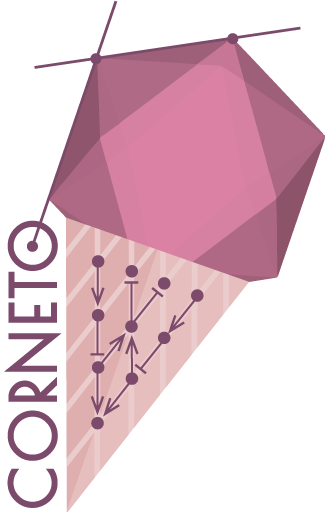

In [135]:
cn.info()

In [136]:
#Find PBFs causal network using 
df_res, problem = li.mt.find_causalnet(
    prior_graph,
    input_scores,
    output_scores,
    node_weights,
    # penalize (max_penalty) nodes with counts in less than 0.1 of the cells
    node_cutoff=0.1,
    max_penalty=1,
    # the penaly of those in > 0.1 prop of cells set to:
    min_penalty=0.01,
    edge_penalty=0.1,
    verbose=True,
    max_runs=25, # NOTE that this repeats the solving either until the max runs are reached
    stable_runs=5, # or until 5 consequitive stable runs are reached (i.e. no new edges are added)
    solver='scipy'
    )

Total positive/negative scores of the inputs and outputs:
 - (-) input nodes: -4.849467754364014
 - (+) input nodes: 12.859615832567215
 - (-) output nodes: -15.347507238388062
 - (+) output nodes: 25.961055506020784
 - abs total (inputs + outputs): 59.017646331340075
Building CORNETO problem...
Solving with scipy...


                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Jul 16 02:27:17 PM: Your problem has 9670 variables, 31 constraints, and 0 parameters.
(CVXPY) Jul 16 02:27:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 16 02:27:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 16 02:27:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 16 02:27:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 16 02:27:17 PM: Compiling problem (target solver=SCIPY).


Done.
Solution summary:
 - Loss (unfitted inputs/output): [5.26894982]
 - Edge penalty error: 22.999999999999936
 - Node penalty error: 0.08


## Visualize the inferred network


<div class="alert alert-info">
<b>Paper Figure!</b>
Plot Panel Figure 3G
</div>

In [ ]:
#PBFs cells
cn.methods.carnival.visualize_network(df_res)

### Modules and their versions used for this analysis


Useful for debugging and reporting issues.

In [138]:
cell2location.utils.list_imported_modules()

sys 3.9.18 (main, Sep 11 2023, 13:41:44) 
[GCC 11.2.0]
re 2.2.1
ipykernel._version 6.25.2
json 2.0.9
jupyter_client._version 8.3.1
platform 1.0.8
_ctypes 1.1.0
ctypes 1.1.0
zmq.sugar.version 25.1.1
zmq.sugar 25.1.1
zmq 25.1.1
logging 0.5.1.2
traitlets._version 5.10.0
traitlets 5.10.0
jupyter_core.version 5.3.1
jupyter_core 5.3.1
tornado 6.3.3
zlib 1.0
_curses b'2.2'
socketserver 0.4
argparse 1.1
dateutil._version 2.8.2
dateutil 2.8.2
six 1.16.0
_decimal 1.70
decimal 1.70
platformdirs.version 3.10.0
platformdirs 3.10.0
_csv 1.0
csv 1.0
jupyter_client 8.3.1
ipykernel 6.25.2
IPython.core.release 8.15.0
executing.version 1.2.0
executing 1.2.0
pure_eval.version 0.2.2
pure_eval 0.2.2
stack_data.version 0.6.2
stack_data 0.6.2
pygments 2.16.1
ptyprocess 0.7.0
pexpect 4.8.0
IPython.core.crashhandler 8.15.0
pickleshare 0.7.5
backcall 0.2.0
decorator 5.1.1
_sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
sqlite3 2.6.0
exceptiongroup._version 1.1.3
exceptiongroup 1.1.3
wcwidth 0.2.6
prompt_toolkit 3.0.39
parso